In [1]:
from dask.distributed import LocalCluster
# from dask_jobqueue import SLURMCluster
from dask.distributed import Client

cluster = LocalCluster()
# cluster = SLURMCluster(cores=24, name='test', walltime='00:30:00',
#                        job_extra=['--constraint=HSW24','--exclusive','--nodes=1'], 
#                        memory='512GB', interface='ib0'
#                       ) 
cluster.scale(24)
# # cluster.adapt(minimum=1, maximum=48)

client = Client(cluster)
# client = Client()
client

/scratch/cnt0024/hmg2840/tuchida/envs/mai2021/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36952 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:46256 Dashboard: http://127.0.0.1:36952/status,Cluster Workers: 24 Cores: 168 Memory: 754.89 GiB


In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import time
# import numpy_groupies
import dask.array as dsar
import xrft
import qgutils
from xgcm.grid import Grid
import os.path as op
# from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ddir = '/store/CT1/hmg2840/tuchida/msqg/seas-forcing/'
rund = '/store/tuchida/msom/msqg/'
# ddir = '/store/CT1/hmg2840/tuchida/msqg/const-forcing/'

In [4]:
U = .1
T = 5e5      # seconds
tau0 = .0001
dt = 5e-2
Rd = 5e4     # Rossby radius (50km)
Re4 = 4e3
# f0 = 8e-5
beta = .5
N = 256*4    # Number of horizontal grids
L0 = 80
H = 5e3
dx = L0/N    # Non-dimensionalized horizontal resolution ((L0*Rd)/N)/Rd
diny = 360
Rom = .025
Ekb = .002*2
ntime = 187

percent = 10
nmemb = 100

In [5]:
def pad_bc(psi, bc='dirichlet'):
    """
    Pad field psi with Dirichlet or Neumann boundary conditions
    Parameters
    ----------
    psi : array [nt,nz (,ny,nx)]
    bc   : 'dirichlet' or 'neumann'
    Returns
    -------
    psi_bc: array [nt,nz (,ny+2,nx+2)]
    """
    nd = psi.ndim
    # only pad horizontal dimensions
    if nd == 4:
        psi = np.pad(psi,((0,0),(0,0),(1,1),(1,1)),'constant')
    elif nd == 5:
        psi = np.pad(psi,((0,0),(0,0),(0,0),(1,1),(1,1)),'constant')

    if (bc == 'dirichlet'): 
        psi[...,0,:]  = -psi[...,1,:]
        psi[...,-1,:] = -psi[...,-2,:]
        psi[...,:,0]  = -psi[...,:,1]
        psi[...,:,-1] = -psi[...,:,-2]
    
        # corners
        psi[...,0,0]   = -psi[...,0,1]   - psi[...,1,0]   - psi[...,1,1]
        psi[...,-1,0]  = -psi[...,-1,1]  - psi[...,-2,0]  - psi[...,-2,1]
        psi[...,0,-1]  = -psi[...,1,-1]  - psi[...,0,-2]  - psi[...,1,-2]
        psi[...,-1,-1] = -psi[...,-1,-2] - psi[...,-2,-2] - psi[...,-2,-1]

    elif (bc == 'neumann'): 
        psi[...,0,:]  = psi[...,1,:]
        psi[...,-1,:] = psi[...,-2,:]
        psi[...,:,0]  = psi[...,:,1]
        psi[...,:,-1] = psi[...,:,-2]
    
        # corners
        psi[...,0,0]   = psi[...,1,1]
        psi[...,-1,0]  = psi[...,-2,1]
        psi[...,0,-1]  = psi[...,1,-2]
        psi[...,-1,-1] = psi[...,-2,-2]

    return psi


def laplacian(psi, Delta=1, bc='dirichlet', padded=False, 
              dim=['Z','Yp1','Xp1'], chunks={'Yp1':100,'Xp1':100}
             ):
    
    nd = psi.ndim
    if padded:
        psi_padded = psi
    else:
        if nd == 3:
            psi_padded = xr.DataArray(qgutils.pad_bc(psi), dims=dim,
                                      coords={'Yp1':np.arange(-dx/2,L0+dx,dx),
                                              'Xp1':np.arange(-dx/2,L0+dx,dx)}
                                     ).chunk(chunks)
        else:
            psi_padded = xr.DataArray(pad_bc(psi), dims=dim,
                                      coords={'Yp1':np.arange(-dx/2,L0+dx,dx),
                                              'Xp1':np.arange(-dx/2,L0+dx,dx)}
                                     ).chunk(chunks)

    lap = (psi_padded.isel(Yp1=slice(2,None),Xp1=slice(1,-1)).data 
           + psi_padded.isel(Yp1=slice(None,-2),Xp1=slice(1,-1)).data
           + psi_padded.isel(Yp1=slice(1,-1),Xp1=slice(2,None)).data 
           + psi_padded.isel(Yp1=slice(1,-1),Xp1=slice(None,-2)).data
           - 4*psi_padded.isel(Yp1=slice(1,-1),Xp1=slice(1,-1)).data
          ) / Delta**2

    return xr.DataArray(lap, dims=psi_padded.dims, 
                        coords=psi_padded.isel(Yp1=slice(1,-1),Xp1=slice(1,-1)).coords
                       )

In [6]:
def _dot3D(self, other):
    func = np.dot(self[0,0,0], other[0,0,0])
#     return np.expand_dims(func, (0,1,2))
    return func[np.newaxis,np.newaxis,np.newaxis,:,:]

def _dot2D(self, other):
    func = np.dot(self[0,0], other[0,0])
#     return np.expand_dims(func, (0,1))
    return func[np.newaxis,np.newaxis,:,:]

In [7]:
ds = xr.open_zarr(op.join(rund, 'ctrl/vars001'))
dsb = xr.open_zarr(op.join(rund,"MeanPTR001/%03d-%03d" 
                   % (0,6))).isel(Z=0)
dsp = xr.open_zarr(op.join(rund,"EddyFlux001/%03d-%03d" 
                   % (0,6))).isel(Z=0)
###################
ncoars = 4
grid = Grid(ds.coarsen(YC=ncoars, XC=ncoars, YG=ncoars, XG=ncoars, boundary='exact').mean(), 
            periodic=[],
            coords={'Y':{'center':'YC','left':'YG'},
                    'X':{'center':'XC','left':'XG'}}
           )
grid

<xgcm.Grid>
Y Axis (not periodic, boundary=None):
  * center   YC --> left
  * left     YG --> center
X Axis (not periodic, boundary=None):
  * center   XC --> left
  * left     XG --> center

In [8]:
dsb.ptr0b.isel(time=0).coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()

<xarray.DataArray 'ptr0b' (YC: 128, XC: 128)>
dask.array<mean_agg-aggregate, shape=(128, 128), dtype=float32, chunksize=(16, 16), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float64 0.3125 0.9375 1.562 2.188 ... 77.81 78.44 79.06 79.69
  * YC       (YC) float64 0.3125 0.9375 1.562 2.188 ... 77.81 78.44 79.06 79.69
    Z        float64 0.03
    time     float32 311.0

distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


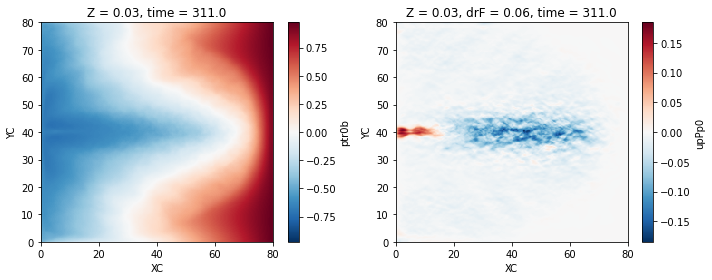

In [13]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
fig.set_tight_layout(True)
dsb.ptr0b.isel(time=0).coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean().plot(ax=ax1)
dsp.upPp0.isel(time=0).coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean().plot(ax=ax2)

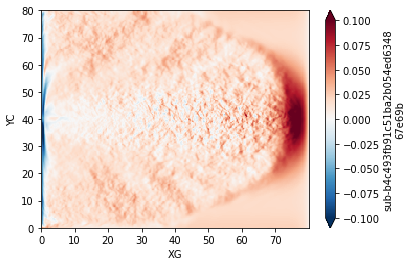

In [14]:
(grid.diff(dsb.ptr0b.isel(time=0).coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean(),'X',boundary='extend') / dx/ncoars).plot(vmax=.1)

<ipython-input-8-865b7d4d1c38>:118: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im0 = axes[0,0].pcolormesh(K.XC*Rd*1e-3, K.YC*Rd*1e-3,
<ipython-input-8-865b7d4d1c38>:121: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im1 = axes[0,1].pcolormesh(K.XC*Rd*1e-3, K.YC*Rd*1e-3,
<ipython-input-8-865b7d4d1c38>:124: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quad

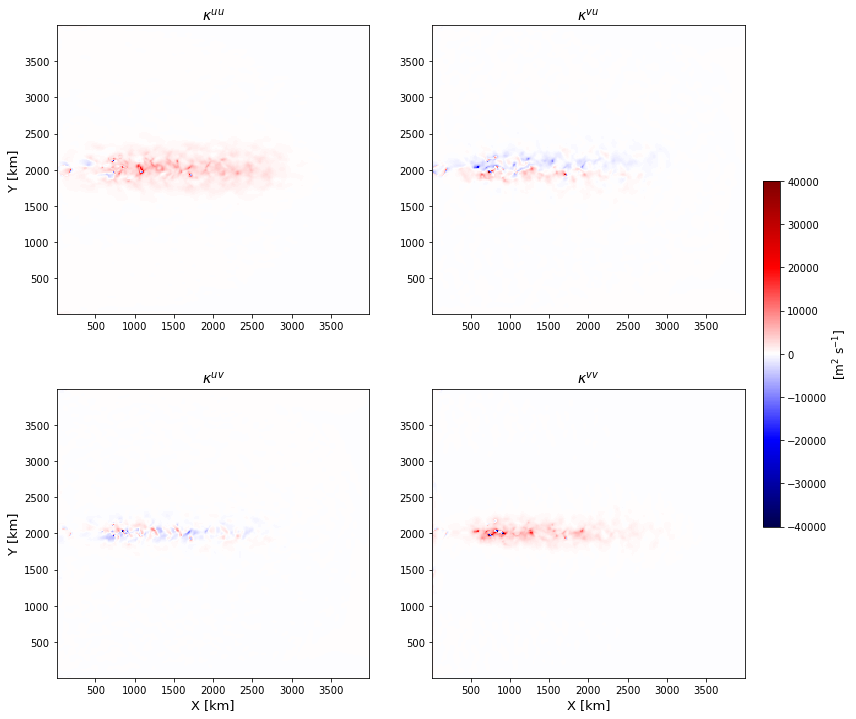

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

35


distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

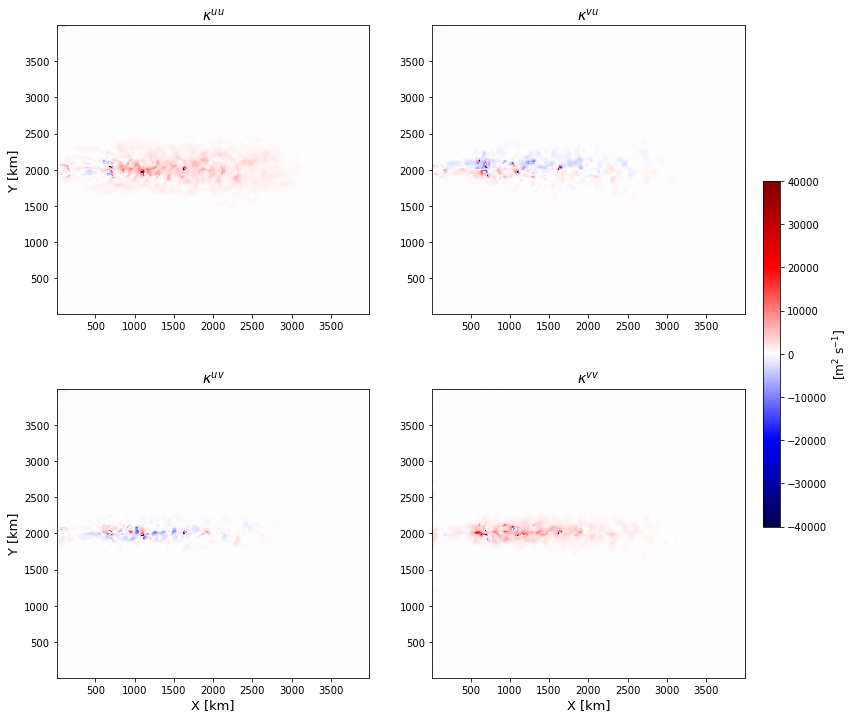

distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

36


distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

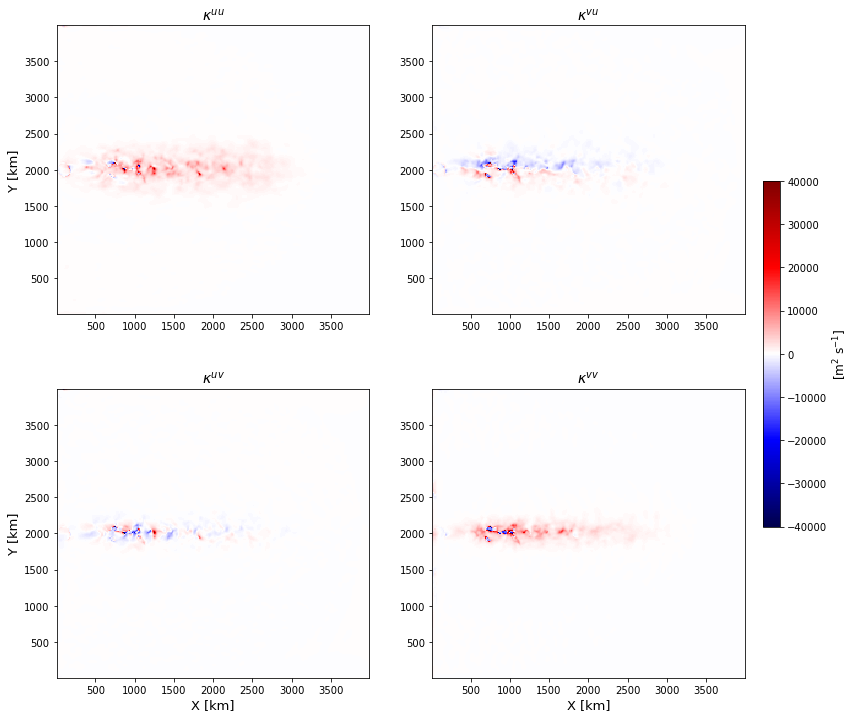

distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

37


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

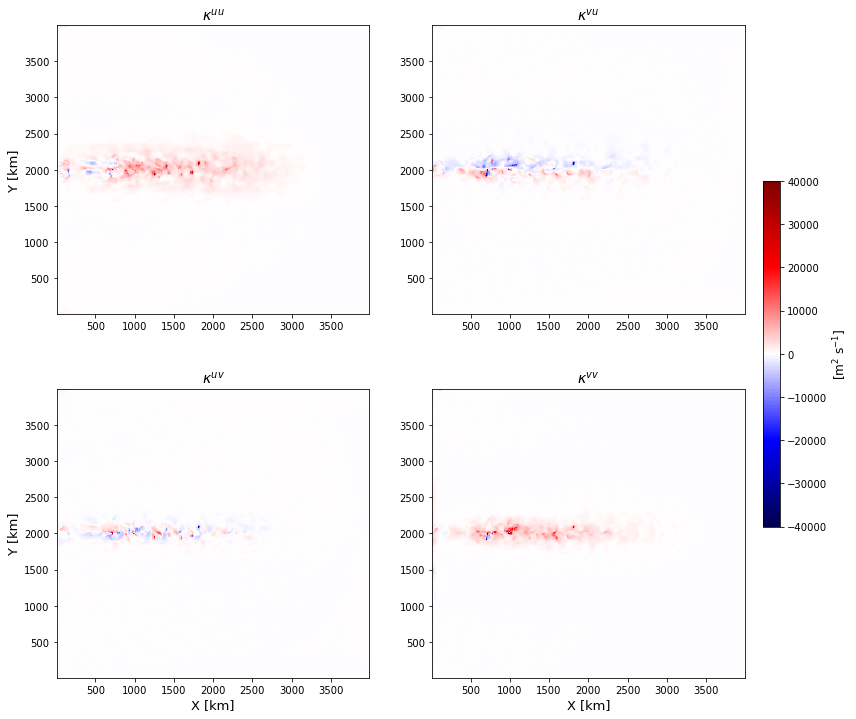

distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

38


distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

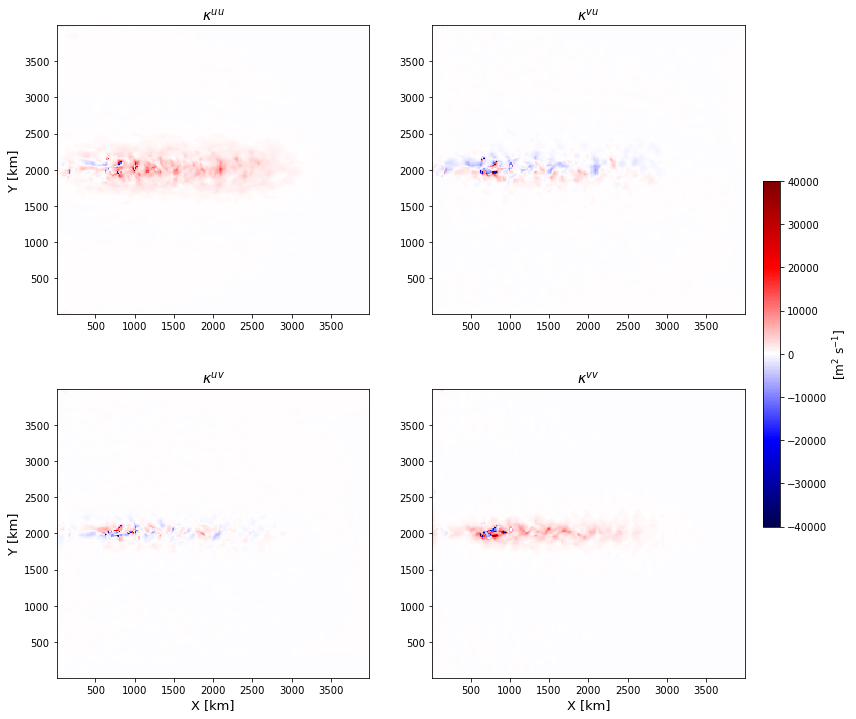

distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

39


distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

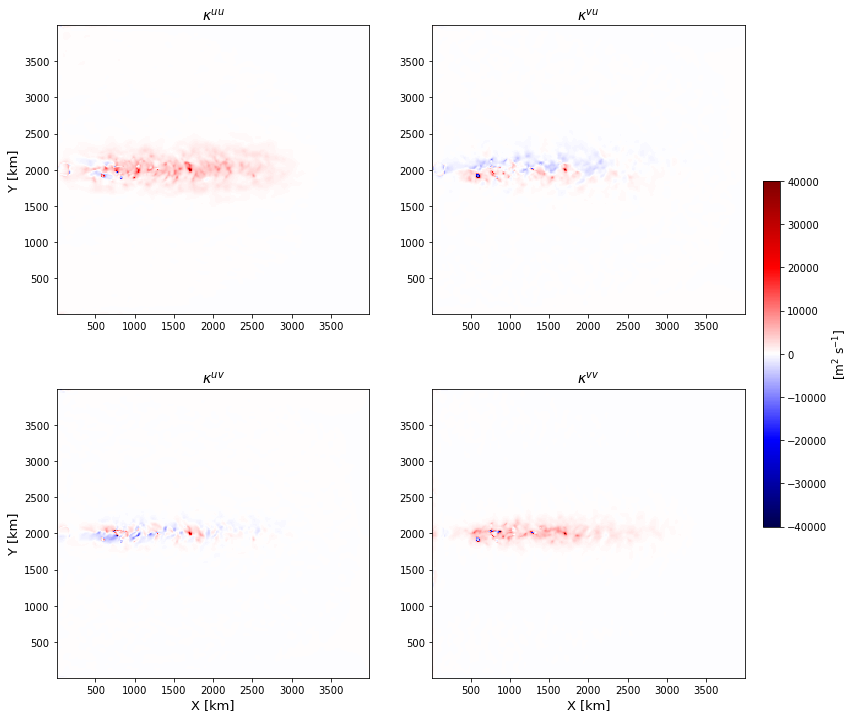

distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

40


distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

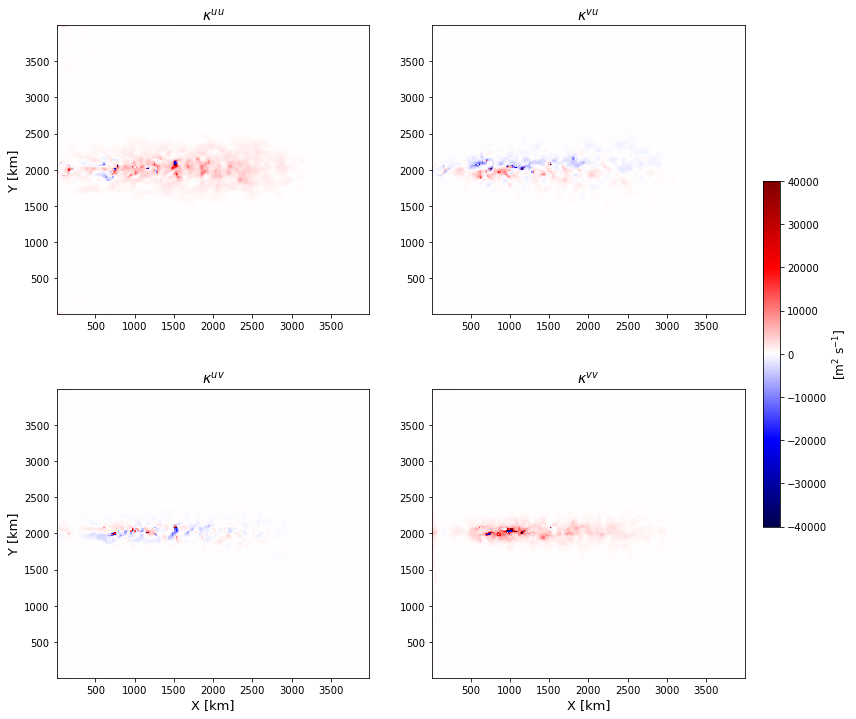

distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

41


distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

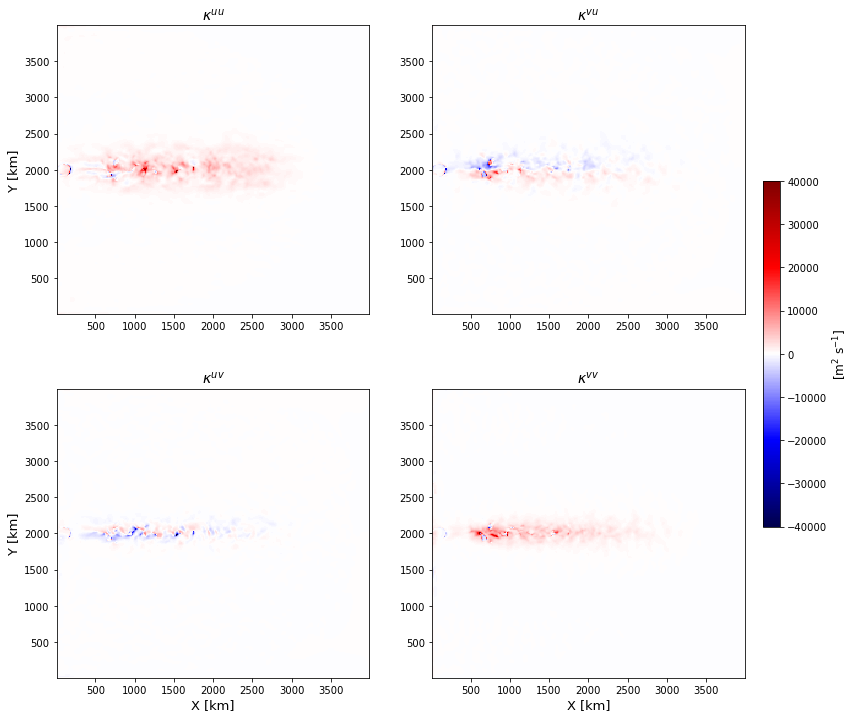

distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

42


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

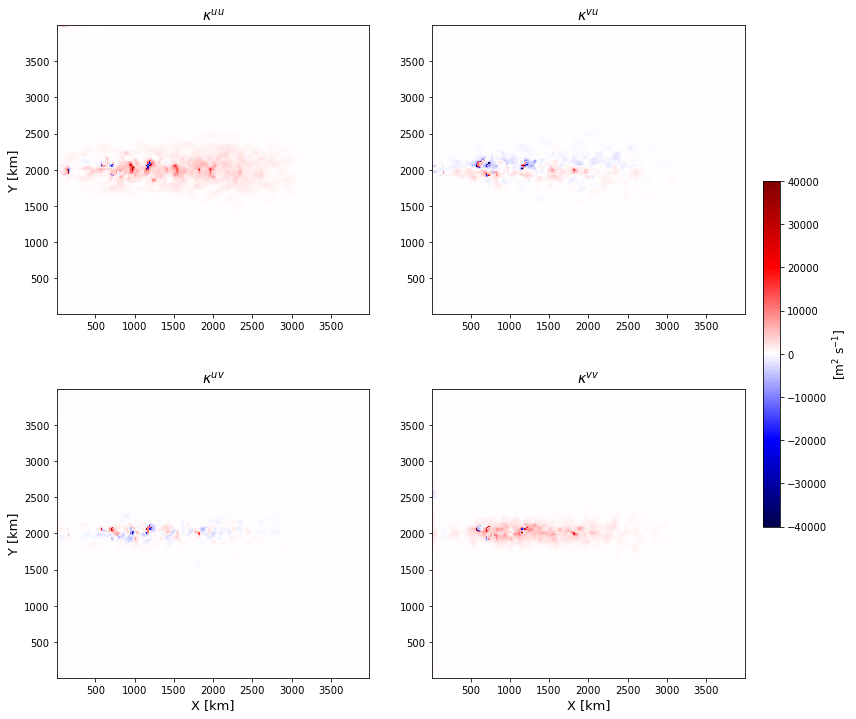

distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

43


distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

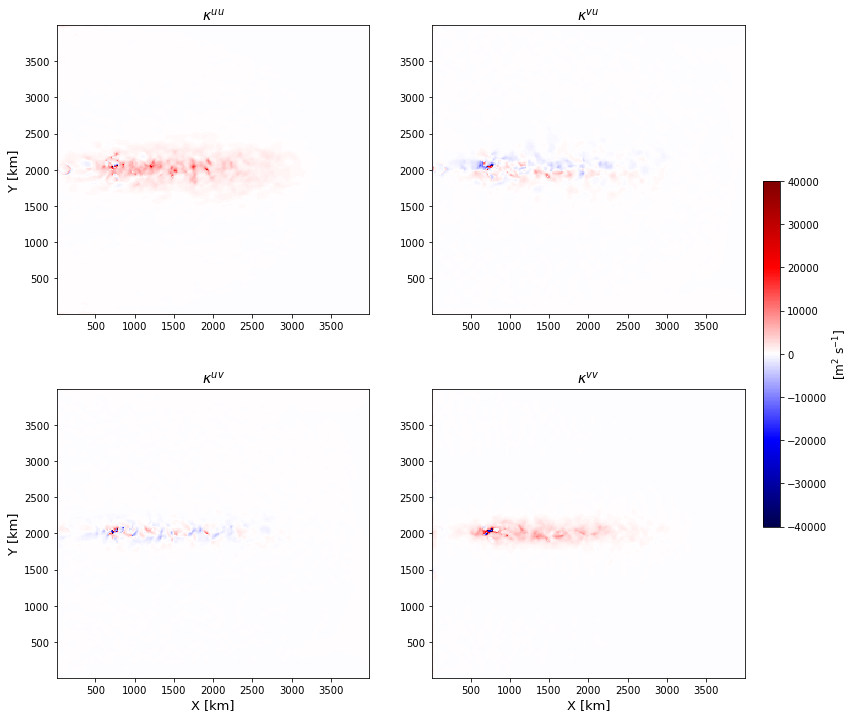

distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

44


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


In [8]:
dtt = 7
iZ = 2
ttstart = 35

D = 1.             # non-dimensionalized eddy length scale: Rd**2
lamb = 62.2**-1    # non-dimensionalized relaxation frequency: 1/T


for tt in range(ttstart,int(312/dtt)+1):
# for tt in range(1):

    if tt < 44:
        dsb = xr.open_zarr(op.join(rund,"MeanPTR001/%03d-%03d" 
                                   % (tt*dtt,tt*dtt+dtt-1))).isel(Z=iZ)
        dsp = xr.open_zarr(op.join(rund,"EddyFlux001/%03d-%03d" 
                                   % (tt*dtt,tt*dtt+dtt-1))).isel(Z=iZ)
    else:
        dsb = xr.open_zarr(op.join(rund,"MeanPTR001/%03d-%03d" 
                                   % (308,311))).isel(Z=iZ)
        dsp = xr.open_zarr(op.join(rund,"EddyFlux001/%03d-%03d" 
                                   % (308,311))).isel(Z=iZ)
    
    P0b = dsb.ptr0b.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
    P1b = dsb.ptr1b.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
    P2b = dsb.ptr2b.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
    P3b = dsb.ptr3b.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
    
    P0 = qgutils.pad_bc(P0b)
    P1 = qgutils.pad_bc(P1b)
    P2 = qgutils.pad_bc(P2b)
    P3 = qgutils.pad_bc(P3b)
    DX = dx * ncoars
    P0x = np.diff(P0[...,1:-1,:], axis=-1) / DX
    P0x = .5*(P0x[...,1:] + P0x[...,:-1])
    P0y = np.diff(P0[...,1:-1], axis=-2) / DX
    P0y = .5*(P0y[...,1:,:] + P0y[...,:-1,:])
    P1x = np.diff(P1[...,1:-1,:], axis=-1) / DX
    P1x = .5*(P1x[...,1:] + P1x[...,:-1])
    P1y = np.diff(P1[...,1:-1], axis=-2) / DX
    P1y = .5*(P1y[...,1:,:] + P1y[...,:-1,:])
    P2x = np.diff(P2[...,1:-1,:], axis=-1) / DX
    P2x = .5*(P2x[...,1:] + P2x[...,:-1])
    P2y = np.diff(P2[...,1:-1], axis=-2) / DX
    P2y = .5*(P2y[...,1:,:] + P2y[...,:-1,:])
    P3x = np.diff(P3[...,1:-1,:], axis=-1) / DX
    P3x = .5*(P3x[...,1:] + P3x[...,:-1])
    P3y = np.diff(P3[...,1:-1], axis=-2) / DX
    P3y = .5*(P3y[...,1:,:] + P3y[...,:-1,:])
#     P0x = grid.interp(grid.diff(P0b,'X',boundary='extend'),'X',boundary='extend') / DX
#     P0y = grid.interp(grid.diff(P0b,'Y',boundary='extend'),'Y',boundary='extend') / DX
#     P1x = grid.interp(grid.diff(P1b,'X',boundary='extend'),'X',boundary='extend') / DX
#     P1y = grid.interp(grid.diff(P1b,'Y',boundary='extend'),'Y',boundary='extend') / DX
#     P2x = grid.interp(grid.diff(P2b,'X',boundary='extend'),'X',boundary='extend') / DX
#     P2y = grid.interp(grid.diff(P2b,'Y',boundary='extend'),'Y',boundary='extend') / DX
#     P3x = grid.interp(grid.diff(P3b,'X',boundary='extend'),'X',boundary='extend') / DX
#     P3y = grid.interp(grid.diff(P3b,'Y',boundary='extend'),'Y',boundary='extend') / DX

    K = xr.DataArray(np.ones((len(dsb.time),len(dsb.YC)//ncoars,len(dsb.XC)//ncoars,
                              2,2)
                            )*np.nan,
                     dims=['time','YC','XC','row','col'],
                     coords={'time':dsb.time.data,
                             'YC':P0b.YC.data,
                             'XC':P0b.XC.data}
                    )
#     start = time.time()
    for itime in range(len(dsb.time)):
##############################
##############################
        G = xr.DataArray(np.ones((len(dsb.YC.data)//ncoars,len(dsb.XC.data)//ncoars,
                                  4,2)
                                )*np.nan,
                         dims=['YC','XC','row','col']
                        )
        G[...,0,0] = -P0x[itime]
        G[...,0,1] = -P0y[itime]
        G[...,1,0] = -P1x[itime]
        G[...,1,1] = -P1y[itime]
        G[...,2,0] = -P2x[itime]
        G[...,2,1] = -P2y[itime]
        G[...,3,0] = -P3x[itime]
        G[...,3,1] = -P3y[itime]

        invG = xr.DataArray(dsar.map_blocks(np.linalg.pinv, 
                                            G.chunk({'YC':1,'XC':1}).data).compute(),
                            dims=['YC','XC','row','col']
                           )
        del G

        F = xr.DataArray(np.ones((len(dsb.YC)//ncoars,len(dsb.XC)//ncoars,4,2)
                                )*np.nan,
                         dims=['YC','XC','row','col']
                        )
        F[...,0,0] = dsp.upPp0.isel(time=itime).coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
        F[...,0,1] = dsp.vpPp0.isel(time=itime).coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
        F[...,1,0] = dsp.upPp1.isel(time=itime).coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
        F[...,1,1] = dsp.vpPp1.isel(time=itime).coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
        F[...,2,0] = dsp.upPp2.isel(time=itime).coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
        F[...,2,1] = dsp.vpPp2.isel(time=itime).coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
        F[...,3,0] = dsp.upPp3.isel(time=itime).coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
        F[...,3,1] = dsp.vpPp3.isel(time=itime).coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
        
        F[...,0,0] = F[...,0,0] + P0x[itime] * D * lamb
        F[...,0,1] = F[...,0,1] + P0y[itime] * D * lamb
        F[...,1,0] = F[...,1,0] + P1x[itime] * D * lamb
        F[...,1,1] = F[...,1,1] + P1y[itime] * D * lamb
        F[...,2,0] = F[...,2,0] + P2x[itime] * D * lamb
        F[...,2,1] = F[...,2,1] + P2y[itime] * D * lamb
        F[...,3,0] = F[...,3,0] + P3x[itime] * D * lamb
        F[...,3,1] = F[...,3,1] + P3y[itime] * D * lamb

        K.isel(time=itime)[:] = dsar.map_blocks(_dot2D, invG.chunk({'YC':1,'XC':1}).data, 
                                                F.chunk({'YC':1,'XC':1}).data,
                                                chunks=(1,1,2,2)
                                               ).compute()
        if itime == 0:
            fig, axes = plt.subplots(figsize=(13,12), nrows=2, ncols=2)
            im0 = axes[0,0].pcolormesh(K.XC*Rd*1e-3, K.YC*Rd*1e-3, 
                                       K[...,0,0].isel(time=itime)*U*Rd, 
                                       vmin=-4e4, vmax=4e4, cmap='seismic', rasterized=True)
            im1 = axes[0,1].pcolormesh(K.XC*Rd*1e-3, K.YC*Rd*1e-3, 
                                       K[...,0,1].isel(time=itime)*U*Rd, 
                                       vmin=-4e4, vmax=4e4, cmap='seismic', rasterized=True)
            im2 = axes[1,0].pcolormesh(K.XC*Rd*1e-3, K.YC*Rd*1e-3,
                                       K[...,1,0].isel(time=itime)*U*Rd, 
                                       vmin=-4e4, vmax=4e4, cmap='seismic', rasterized=True)
            im3 = axes[1,1].pcolormesh(K.XC*Rd*1e-3, K.YC*Rd*1e-3, 
                                       K[...,1,1].isel(time=itime)*U*Rd, 
                                       vmin=-4e4, vmax=4e4, cmap='seismic', rasterized=True)
            axes[0,0].set_title(r"$\kappa^{uu}$", fontsize=14)
            axes[0,1].set_title(r"$\kappa^{vu}$", fontsize=14)
            axes[1,0].set_title(r"$\kappa^{uv}$", fontsize=14)
            axes[1,1].set_title(r"$\kappa^{vv}$", fontsize=14)
            axes[1,0].set_xlabel(r"X [km]", fontsize=13)
            axes[1,1].set_xlabel(r"X [km]", fontsize=13)
            axes[0,0].set_ylabel(r"Y [km]", fontsize=13)
            axes[1,0].set_ylabel(r"Y [km]", fontsize=13)
            fig.subplots_adjust(right=0.86, hspace=.26) 
            cbax0 = fig.add_axes([0.88, 0.3, 0.018, 0.4])
            cbar0 = fig.colorbar(im0, orientation='vertical', cax=cbax0)
            cbar0.set_label(r"[m$^2$ s$^{-1}$]", fontsize=12)
            plt.show()

        del F, invG
#         end = time.time()
#         print('Lapse time:', end-start)
        
    K.to_dataset(name='K').to_zarr(op.join(rund,'Kappas001/Z%1d/n%02d_%03d-%03d_opt/' 
                                   % (iZ,ncoars,tt*dtt,tt*dtt+len(dsb.time)-1)), 
                                   mode='w')

##############################
    #             plt.savefig(op.join(ddir,
    #                             'Figures/Kappas_5Dave_isig25_nhskip%1d-%010d.pdf'
    #                                 % (nhskip,itime)))


    del K
#         print(itime)
    dsp.close()
    dsb.close()
        
    print(tt)

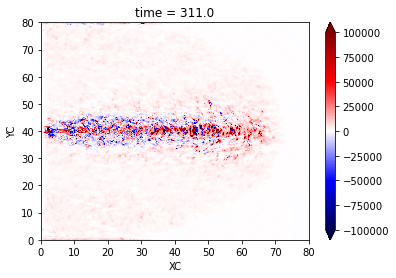

In [14]:
(K[0,:,:,0,0]*Rd**2/T).plot(vmax=1e5,cmap='seismic')

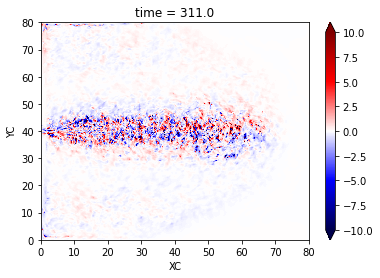

In [12]:
K[0,:,:,0,1].plot(vmax=10, cmap='seismic')